<a href="https://colab.research.google.com/github/DevashishX/CaptchaBreaker/blob/master/CaptchaBreaker_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf ./CaptchaBreaker ; git clone https://github.com/DevashishX/CaptchaBreaker.git
!ls -lh

#remove an image with 6 letter name
!rm -f /content/CaptchaBreaker/samples/3bnfnd.*

Cloning into 'CaptchaBreaker'...
remote: Enumerating objects: 1085, done.
remote: Counting objects: 100% (1085/1085), done.
remote: Compressing objects: 100% (1084/1084), done.
remote: Total 1085 (delta 3), reused 1080 (delta 1), pack-reused 0
Receiving objects: 100% (1085/1085), 25.75 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.
total 8.0K
drwxr-xr-x 4 root root 4.0K Jul 28 16:41 CaptchaBreaker
drwxr-xr-x 1 root root 4.0K Jul 10 16:29 sample_data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import scipy
import os, sys

In [3]:
alphabet = u"0123456789abcdefghijklmnopqrstuvwxyz "
token_classes = len(alphabet)
assert len(alphabet) == 37

def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret

def labels_to_text(labels):
    ret = []
    for c in labels:
        c = int(c)
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)

In [4]:
imgdir = "/content/CaptchaBreaker/samples" # path to where images are stored
imgnames = os.listdir(imgdir)
print(imgnames, len(imgnames), sep="\n")

['fg7mg.png', '428b6.png', '3n7mx.png', '65m85.png', 'm8gmx.png', 'xw465.png', 'gxxpf.png', 'd8dce.png', 'b55d6.png', '7634y.png', 'ny3dw.png', '5bg8f.png', 'de7f8.png', '8bbm4.png', 'xdn65.png', '82fx2.png', '467d5.png', '7e2y7.png', '5npdn.png', 'p24gn.png', 'g8gnd.png', '47e4p.png', '24f6w.png', '7f8b3.png', '244e2.png', 'f753f.png', 'w8bnx.png', 'dw6mn.png', '646x8.png', '4yc85.png', 'een23.png', 'ef4mn.png', 'nb45d.png', 'p4nm4.png', 'ncyx8.png', 'n2c85.jpg', '5nm6d.png', 'xe8xm.png', 'n336e.png', '2nx38.png', 'pm363.png', 'b4d7c.png', 'fcne6.png', '8npe3.png', 'ygce8.jpg', '6fg8c.png', 'g7fmc.png', 'gw53m.png', '8d2nd.png', 'x2cnn.png', '6ng6w.png', 'd7c5x.png', '6ydyp.png', 'x277e.png', 'bd3b7.png', 'dbfen.png', '3ygde.png', 'f2m8n.png', 'p2x7x.png', 'gegw4.png', '6xen4.png', 'g3ex3.png', 'b3xpn.png', 'nnp4e.png', '6f2yc.png', '3ebnn.png', 'gd8fb.png', 'cwgyx.png', '22d5n.png', '2g783.png', 'm4fd8.png', '44xe8.png', '7wn74.png', 'gcfgp.png', 'd378n.png', 'wce5n.png', 'm74dm.png'

In [5]:
def imagereader(filename, imgdir):
    img = Image.open(os.path.join(imgdir, filename)).convert('LA')
    img = np.array(img, np.float32)[:,:,:1]/255.0
    return img

In [6]:
img1 = imagereader(imgnames[0], imgdir)
print(img1.shape)

(50, 200, 1)


In [7]:
datadict = {"imgpath":[], "label":[], "label_len":[]}

for name in imgnames:
    imgpath = os.path.join(imgdir, name)
    label = name.split(".")[0]
    label_len = len(label)

    datadict["imgpath"].append(imgpath)
    datadict["label"].append(label)
    datadict["label_len"].append(label_len)

data = pd.DataFrame(datadict)

max_label_length = max(data["label_len"])
print(max_label_length)
# print(data["label_len"][0])
print(data.head())
del(datadict)

5
                                     imgpath  label  label_len
0  /content/CaptchaBreaker/samples/fg7mg.png  fg7mg          5
1  /content/CaptchaBreaker/samples/428b6.png  428b6          5
2  /content/CaptchaBreaker/samples/3n7mx.png  3n7mx          5
3  /content/CaptchaBreaker/samples/65m85.png  65m85          5
4  /content/CaptchaBreaker/samples/m8gmx.png  m8gmx          5


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [9]:
def image_array(data, img_wt=200, img_ht=50, img_ch=1):
    n_img = len(data)
    PIL_size = (img_wt, img_ht)
    images = np.zeros((n_img, img_ht, img_wt, img_ch), dtype=np.float32)
    imgpath = data["imgpath"].tolist()
    for n in range(n_img):
        img = Image.open(imgpath[n]).convert('LA')
        if img.size != PIL_size:
            print("resize: {} to {}".format(img.size, PIL_size))
            img = img.resize(PIL_size, Image.ANTIALIAS)
        img = np.array(img, np.float32)[:,:,:img_ch]/255.0
        images[n] = img
    # print(images.shape)
    return images

In [10]:
def label_array(data, max_label_length):
    n_labels = len(data)
    label_emb = np.zeros((n_labels, max_label_length), dtype=np.float32)
    label_len = np.zeros((n_labels, 1), dtype=np.int)

    for i in range(len(data["label"])):
        label_emb[i] = text_to_labels(data["label"][i])
        label_len[i] = data["label_len"][i]

    return label_emb, label_len

In [11]:
import tensorflow as tf
import math

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    """
    Data to be returned:
    X = X_images, y_true, input_length, label_length
    X_images        numpy  (samples, image_height, image_width, image_channels)
    y_true         	tensor (samples, max_string_length) containing the truth labels.
    # y_pred	        tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
    input_length	tensor (samples, 1) containing the sequence length for each batch item in y_pred.
    label_length	tensor (samples, 1) containing the sequence length for each batch item in y_true.

    Y = np.zeros(batch_length, dtype=np.float32)
    Y should ideally be the labels but we are giving in labels via X so that we can calculate
    losss in the final ctc layer.
    We are just going to pass dummy zeros array
    """
    def __init__(self,
                 df=train_data,
                 batch_size=32,
                 img_wt=200,
                 img_ht=50,
                 img_ch=1,
                 softmax_time_steps=47,
                 downsample=4,
                 max_label_length=max_label_length,
                 shuffle=False
                 ):
        self.df = df
        self.batch_size = batch_size
        self.img_wt = img_wt
        self.img_ht = img_ht
        self.img_ch = img_ch
        self.softmax_time_steps = softmax_time_steps #Number of time slices which will be generated by final softmax layer
        self.downsample = downsample
        self.max_label_length = max_label_length
        self.shuffle = shuffle
        self.indices = np.arange(len(df))    
        self.on_epoch_end()
        pass
    
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):

        global_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_len = len(global_idx)

        X_images = np.zeros((batch_len, self.img_ht, self.img_wt, self.img_ch), dtype=np.float32)
        y_true = np.zeros((batch_len, self.max_label_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1)) # for y_pred - number of total timesteps generated by final softmax layer will go here
        label_length = np.ones((batch_len, 1)) # for y_true - number of tokens in y_true labels

        local_data = self.df.iloc[global_idx].reset_index(drop=True)

        X_images = image_array(local_data, self.img_wt, self.img_ht, self.img_ch)
        y_true, label_length = label_array(local_data, self.max_label_length)
        input_length = input_length*self.softmax_time_steps

        batch_inputs = {
                'X_images': X_images,
                'y_true': y_true,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, y_true

        pass


    

In [13]:
batch_size=64
img_wt=200
img_ht=50
img_ch=1
softmax_time_steps=47
downsample=4
max_label_length=max_label_length
shuffle=False

In [14]:
train_generator = DataGenerator(train_data,
                                batch_size=batch_size,
                                img_wt=img_wt,
                                img_ht=img_ht,
                                img_ch=img_ch,
                                softmax_time_steps=softmax_time_steps,
                                downsample=downsample,
                                max_label_length=max_label_length,
                                shuffle=shuffle
                                )

val_generator = DataGenerator(val_data,
                                batch_size=batch_size,
                                img_wt=img_wt,
                                img_ht=img_ht,
                                img_ch=img_ch,
                                softmax_time_steps=softmax_time_steps,
                                downsample=downsample,
                                max_label_length=max_label_length,
                                shuffle=shuffle
                                )

In [15]:
# item = train_generator.__getitem__(1)
# print([(d.shape, d[0]) for d in item[0].values()])
# print(item[1].shape, item[1][0])

# Create Model

In [16]:
# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
    y_pred, y_true, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [17]:
def getCRNN(img_height=img_ht, img_width=img_wt, img_chan=img_ch, token_classes=token_classes, max_label_length=max_label_length):


    image = tf.keras.Input(shape=(img_height, img_width, img_chan), name = "X_images", dtype="float32")

    # print((img_height, img_width, img_chan))

    y_true = tf.keras.layers.Input(name='y_true', shape=[max_label_length], dtype='float32')
    input_length = tf.keras.layers.Input(name='input_length', shape=[1], dtype='float32')
    label_length = tf.keras.layers.Input(name='label_length', shape=[1], dtype='float32')

    x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", name="conv2d_1")(image)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", name="conv2d_2")(x)
    x = tf.keras.layers.MaxPool2D((2, 2), name="maxpool2d_1")(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", name="conv2d_3")(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", name="conv2d_4")(x)
    x = tf.keras.layers.MaxPool2D((2, 2), name="maxpool2d_2")(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation="relu", name="1d_conv2d_1")(x)


    x = tf.squeeze(x, [3])
    x = tf.keras.layers.Permute((2, 1), input_shape=x.get_shape(), name="permute_1")(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2), name="BiLSTM_1")(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2), name="BiLSTM_2")(x)

    y_pred = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(token_classes+1, activation="softmax"), name="TimeDense")(x)

    print(f"image: {image.get_shape()}", f"y_true: {y_true.get_shape()}", f"y_pred: {y_pred.get_shape()}",
          f"input_length: {input_length.get_shape()}", f"label_length: {label_length.get_shape()}", sep="\n")

    # output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, y_true, input_length, label_length])

    model = tf.keras.models.Model(inputs=[image,
                                       y_true,
                                       input_length,
                                       label_length],
                                outputs=[loss_out],
                                name='CRNN_CTC_Model')
    return model, y_true, input_length, label_length

In [18]:
model, y_true, input_length, label_length = getCRNN(img_height=img_ht, img_width=img_wt,
                                                    img_chan=img_ch, token_classes=token_classes,
                                                    max_label_length=max_label_length)

image: (None, 50, 200, 1)
y_true: (None, 5)
y_pred: (None, 47, 38)
input_length: (None, 1)
label_length: (None, 1)


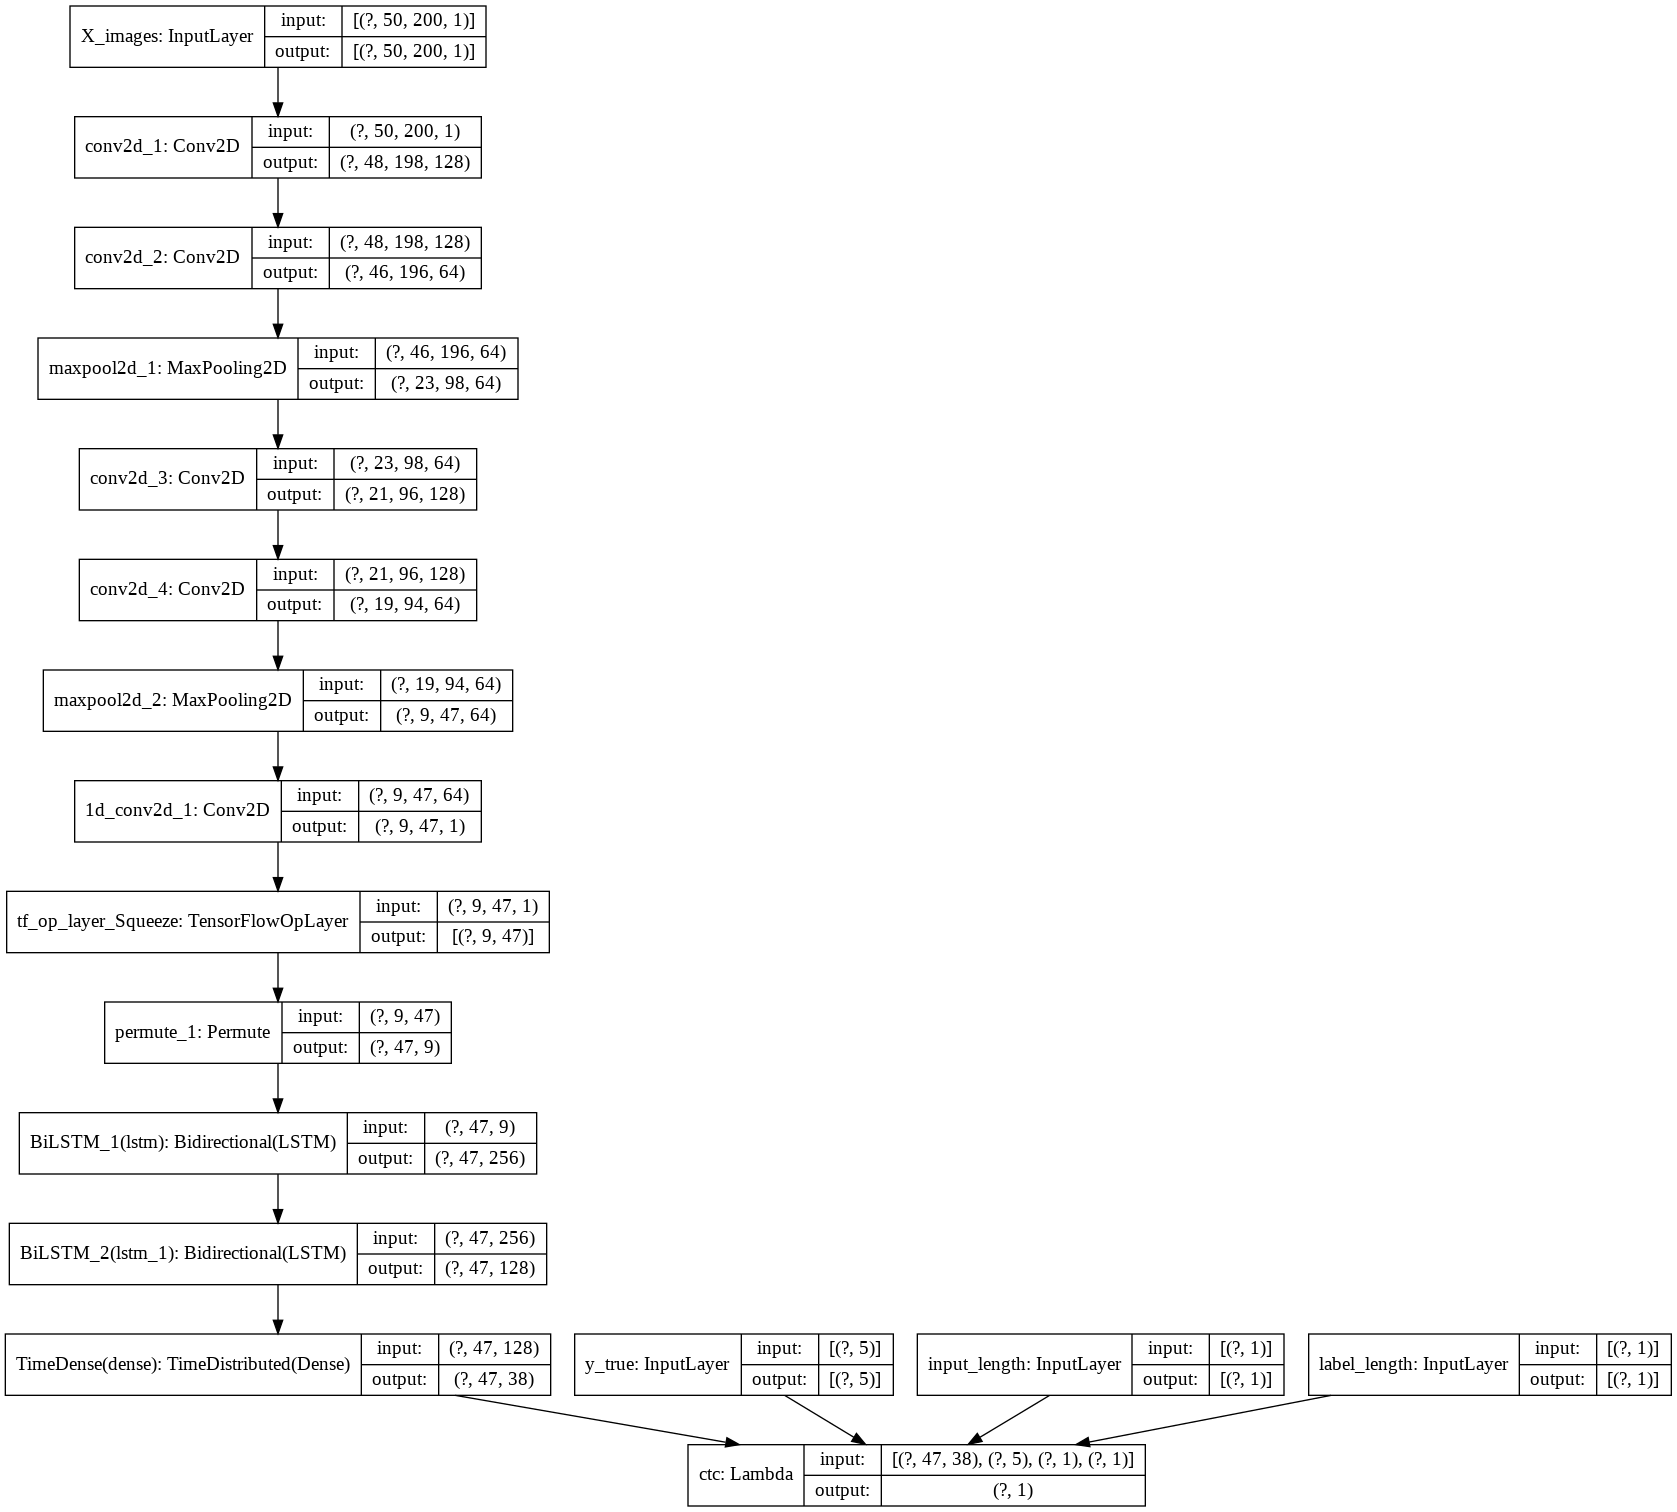

In [19]:
from tensorflow.keras.layers import Layer
model._layers = [
    layer for layer in model._layers if isinstance(layer, Layer)
]
plot = tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)
display(plot)

In [20]:

def ctc_loss_gen(y_true_tokens, input_length, label_length):

    def ctc_loss(y_true, y_pred):
        loss = tf.keras.backend.ctc_batch_cost(y_true_tokens, y_pred, input_length, label_length)
        return loss

    return ctc_loss


In [21]:
def ctc_decode(y_pred, max_label_length=max_label_length):
    input_length = np.ones((y_pred.shape[0]), dtype=np.float32)*y_pred.shape[1]
    # input_length = max_label_length
    results = tf.keras.backend.ctc_decode(y_pred, input_length,
                                         greedy=True)
    decoded_tokens = []
    for r in results:
        decoded_tokens.append(labels_to_text(r))
    
    return decoded_tokens

In [22]:
def ctc_acc_gen(y_true_tokens, batch_size=batch_size, max_label_length=max_label_length):
    print(type(max_label_length))

    def ctc_acc(y_true, y_pred):
        print("y_true: ", y_true, y_true.get_shape())
        print("y_pred: ", y_pred, y_pred.get_shape())
        input_length = np.ones((batch_size, 1), dtype=np.float32)*max_label_length
        result = tf.keras.backend.ctc_decode(y_pred, input_length,
                                             greedy=True, beam_width=100, top_paths=1)
        total = 0
        count = 0
        
        for x, y in zip(y_true, result):
            if all(x == y):
                total = total + 1
        count = len(y_true)

        return total/count
    
    return ctc_acc


In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer="adam")

# model.compile(optimizer="adam", loss=[ctc_loss_gen(y_true, input_length, label_length)], metrics=[ctc_acc_gen(y_true, batch_size, max_label_length)])

In [24]:
model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[es])

Epoch 1/50
14/14 [==============================] - 4s 251ms/step - loss: 94.9722 - val_loss: 27.6552
Epoch 2/50
14/14 [==============================] - 2s 122ms/step - loss: 20.9364 - val_loss: 18.8226
Epoch 3/50
14/14 [==============================] - 2s 118ms/step - loss: 17.3737 - val_loss: 16.8419
Epoch 4/50
14/14 [==============================] - 2s 120ms/step - loss: 16.7006 - val_loss: 16.5341
Epoch 5/50
14/14 [==============================] - 2s 120ms/step - loss: 16.5150 - val_loss: 16.5090
Epoch 6/50
14/14 [==============================] - 2s 117ms/step - loss: 16.4437 - val_loss: 16.4561
Epoch 7/50
14/14 [==============================] - 2s 120ms/step - loss: 16.3927 - val_loss: 16.4091
Epoch 8/50
14/14 [==============================] - 2s 121ms/step - loss: 16.3801 - val_loss: 16.4007
Epoch 9/50
14/14 [==============================] - 2s 120ms/step - loss: 16.3589 - val_loss: 16.3818
Epoch 10/50
14/14 [==============================] - 2s 119ms/step - loss: 16.3532

In [25]:
prediction_model = tf.keras.models.Model(model.get_layer(name='X_images').input,
                                        model.get_layer(name='TimeDense').output)

In [26]:
# #  Let's check results on some validation samples
# for p, (inp_value, _) in enumerate(val_generator):
#     bs = inp_value['X_images'].shape[0]
#     X_data = inp_value['X_images']
#     labels = inp_value['y_true']
    
#     preds = prediction_model.predict(X_data)
#     # print(type(labels), labels.shape, labels)
#     pred_texts = ctc_decode(preds)
#     print(type(pred_texts), pred_texts.shape, pred_texts)
    
    
#     orig_texts = []
#     for label in labels:
#         print(type(label), label.shape, label)

#         # text = ''.join([labels_to_text[int(x)] for x in label])
#         text = labels_to_text([int(x) for x in label])
#         orig_texts.append(text)
        
#     for i in range(bs):
#         print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
#     break

In [46]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    # pred = pred[:, :]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)
    print((results))
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = labels_to_text(res)
        # for c in res:
        #     if c <= len(alphabet) and c >=0:
        #         outstr += labels_to_text([c])
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [47]:
#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(val_generator):
    bs = inp_value['X_images'].shape[0]
    X_data = inp_value['X_images']
    labels = inp_value['y_true']
    
    preds = prediction_model.predict(X_data)
    # print(preds)
    pred_texts = decode_batch_predictions(preds)
    # print(pred_texts, pred_textx.shape)
    
    
    orig_texts = []
    for label in labels:
        text = labels_to_text([int(x) for x in label])
        orig_texts.append(text)
        
    count = 0
    total = len(orig_texts)
    for i in range(bs):
        if orig_texts[i] == pred_texts[i]:
            count += 1

        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    print(f"Accuracy: {count*100/total}%")
    break

([<tf.Tensor: shape=(64, 1), dtype=int64, numpy=
array([[23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23],
       [23]])>], <tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[11.333767],
       [11.333767],
       [11.333767],
      

AttributeError: ignored

In [36]:
model.save("CaptchaModel_WithCTCLayer.h5")
prediction_model.save("CaptchaModel.h5")